In [2]:
!git clone https://github.com/AnirudhKanaparthy/transformers.git

Cloning into 'transformers'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 43 (delta 11), reused 38 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (43/43), 273.93 KiB | 24.90 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [3]:
!mkdir -p data
!wget -O "data/tinyshakespeare.txt" https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-01-07 17:17:50--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘data/tinyshakespeare.txt’

data/tinyshakespear 100%[===================>]   1.06M  --.-KB/s    in 0.02s   

2025-01-07 17:17:50 (47.7 MB/s) - ‘data/tinyshakespeare.txt’ saved [1115394/1115394]



## Import PyDrive so that we can put checkpoints in our Google Drive

In [4]:
!pip install -U -q PyDrive

## Getting tokenizer used by OpenAI

In [5]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.4 MB/s eta 0:00:00


In [6]:
import sys
from datetime import datetime
from pathlib import PosixPath
from typing import Callable, Union

In [7]:
import torch

In [8]:
import tiktoken

Importing `torch` takes time

In [9]:
from google.colab import drive, files

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [11]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [12]:
sys.path.append('/content/transformers')

In [13]:
from transformers.simple_transformer import SimpleDecoderTransformer
from transformers.utils import DataSplit, TransformerConfig, TrainingConfig
from transformers.train import train_transformer
from transformers.tokenizers import TikTokenizer

Authenticate and create PyDrive client

In [14]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Hyper Parameters

In [15]:
# --------------------------------------------------------------------------------------------------- #

dataset_path = 'data/tinyshakespeare.txt'
percent_train = 0.90
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --------------------------------------------------------------------------------------------------- #

In [16]:
f'Running on device: {device}, cuda version: {torch.version.cuda}'

'Running on device: cuda, cuda version: 12.1'

## Loading the Dataset

### Opening and Reading the File

In [17]:
with open(dataset_path, 'r') as fp:
    dataset = fp.read()

### Vocabulary
Creating a vocabulary. Essentially contains all the *tokens* which is recognised by the language model.

In [ ]:
tokenizer = TikTokenizer("r50k_base")

In [20]:
vocab_size = tokenizer.vocabulary_size()
f'Vocabulary size: {vocab_size}'

'Vocabulary size: 50257'

### Encoders and Decoder
We are using a simple method to encode and decode the text data into numbers (integers).

In [21]:
def encode(x): return tokenizer.encode(x)
def decode(x): return tokenizer.decode(x)

test_text = 'This is a sample sentence.'
assert (test_text == decode(encode(test_text)))

### Encoding All the Dataset
We encode all the dataset into numbers.

In [22]:
encoded_dataset = torch.tensor(encode(dataset), dtype=torch.long)

### Split Dataset
We split the dataset to train the model and validate the model. Validation is important as we are trying to generalise the model so that it can produce sentences which are "like" the training data but not exactly the training data.

In [23]:
idx = int(len(encoded_dataset) * percent_train)
train_data, val_data = encoded_dataset[:idx], encoded_dataset[idx:]

In [24]:
def get_data(split: DataSplit) -> torch.Tensor:
    return train_data if split == DataSplit.TRAIN.name else val_data

## Training and Testing the Model

In [ ]:
model_config = TransformerConfig(
    vocabulary_size=vocab_size,
    embedding_dim=384,
    context_length=256,
    number_of_layers=6,
    number_of_heads=6,
    linear_layer_scale=4,
    dropout=0.2,
    device=device
)

In [25]:
train_config = TrainingConfig(
    batch_size=64,
    learning_rate = 3e-4,
    context_length=model_config.context_length,
    maximum_iterations=5000,
    eval_intervals=300,
    eval_iterations=200,
    checkpoint_interval=500,
    checkpoint_dir='./checkpoints',
    device=model_config.device
)

In [26]:
model = SimpleDecoderTransformer(model_config).to(device)

In [27]:
optimizer = torch.optim.AdamW(model.parameters(), lr=train_config.learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=train_config.maximum_iterations)

### Creating a Google Drive folder to store all the checkpoints

In [28]:
#Create folder
folder_name = 'training_' + datetime.now().strftime('%Y-%m-%dT%H:%M:%S')
folder_metadata = {'title' : folder_name, 'mimeType' : 'application/vnd.google-apps.folder'}
folder = drive.CreateFile(folder_metadata)
folder.Upload()

#Get folder info and print to screen
foldertitle = folder['title']
folderid = folder['id']
print('title: %s, id: %s' % (foldertitle, folderid))

title: checkpoint_01/07/2025T17:19:35, id: 131kRCQtkw56VKHK4gke9mouuHuwYPkil


In [29]:
def upload_file(filepath: Union[PosixPath, str]) -> None:
    # This is not working in any browser other than Chrome
    # files.download(checkpoint_path)

    if isinstance(filepath, PosixPath):
        filename = filepath.name
        filepath = str(filepath)
    else:
        filename = filepath.strip().split('/')[-1]

    print(f'Uploading file with, filepath: {filepath}')

    uploaded = drive.CreateFile({ 'title': filename, 'parents': [{ 'id': folderid }] })
    uploaded.SetContentFile(filepath)
    uploaded.Upload()

    print(f'Uploaded file with, id: {uploaded.get("id")}, filepath: {filepath}')

Create a callback for the trainer to use to upload the checkpoints.

In [30]:
def checkpoint_callback(_: dict, checkpoint_path: Union[PosixPath, str]) -> None:
    try:
        upload_file(checkpoint_path)
    except Exception as e:
        print(f'Exception occured while uploading checkpoint: {e}')
        return

In [31]:
all_losses = train_transformer(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    get_data=get_data,
    config=config,
    checkpoint_callback=checkpoint_callback
)

Training:   0%|                                                                                               …

Uploading file with, filepath: checkpoints/checkpoint_499.pt
Exception occured while uploading checkpoint: Redirected but the response is missing a Location: header.
Uploading file with, filepath: checkpoints/checkpoint_999.pt
Exception occured while uploading checkpoint: Redirected but the response is missing a Location: header.
Uploading file with, filepath: checkpoints/checkpoint_1499.pt
Exception occured while uploading checkpoint: Redirected but the response is missing a Location: header.
Uploading file with, filepath: checkpoints/checkpoint_1999.pt
Exception occured while uploading checkpoint: Redirected but the response is missing a Location: header.
Uploading file with, filepath: checkpoints/checkpoint_2499.pt
Exception occured while uploading checkpoint: Redirected but the response is missing a Location: header.
Uploading file with, filepath: checkpoints/checkpoint_2999.pt
Exception occured while uploading checkpoint: Redirected but the response is missing a Location: header.


In [32]:
!zip -r checkpoints/logs.zip checkpoints/logs
upload_file('checkpoints/logs.zip')
upload_file('checkpoints/latest.txt')

  adding: checkpoints/logs/ (stored 0%)
  adding: checkpoints/logs/run_1736270290.log (stored 0%)
Uploading file with, filepath: checkpoints/logs.zip
Uploaded file with, id: 13jiiHSMpKkqBh-L0w4KsXFTGQMxRmTOS, filepath: checkpoints/logs.zip
Uploading file with, filepath: checkpoints/latest.txt
Uploaded file with, id: 14wp7q6J2C7ScVh4W4eG7iE3aVZ5ipeVX, filepath: checkpoints/latest.txt


In [45]:
generate_next_tokens = 500
prompt = ' May GOD help you\n'

idx = torch.tensor([encode(prompt)], dtype=torch.long, device=device)
generation = decode(model.generate(idx, max_next_tokens=generate_next_tokens)[0].tolist())
print(f'Model: {generation}')

Model:  May GOD help you
cuff was there given!

GONZALO:
He'll be hang'd yet,
Half before with such sensible andDropping upon her to
That at prayers! all lost!

Boatswain:
What, must the mouths be cold?

GONZALO:
The hour's assist them,
For our case is as theirs.

SEBASTIAN:
I'm out of patience.

ANTONIO:
We are merely cheated of our lives by drunkards:
This wide-chapp'd rascal--would thou mightst lie drowning
The washing of ten with old cramps,
As who with thee?

GONZALO:
Nath no drowning
The washing of ten tides!

GONZALO:
He'll be hang'd yet,
Though every drop of water swear against it was there given!

SEBASTIAN:
And gape at widest to glut him for an African;
 hearts!

ANTONIO:
The latter end of his commonwealth forgets the
beginning.

GONZALO:
All things in common nature should produce
Without sweat or endeavour: treason, felony,
Sword, pike, knife, gun, or need of any engine,
Would I not have; but nature should bring forth,
Of its own kind, all foison, all abundance,
To feed my i

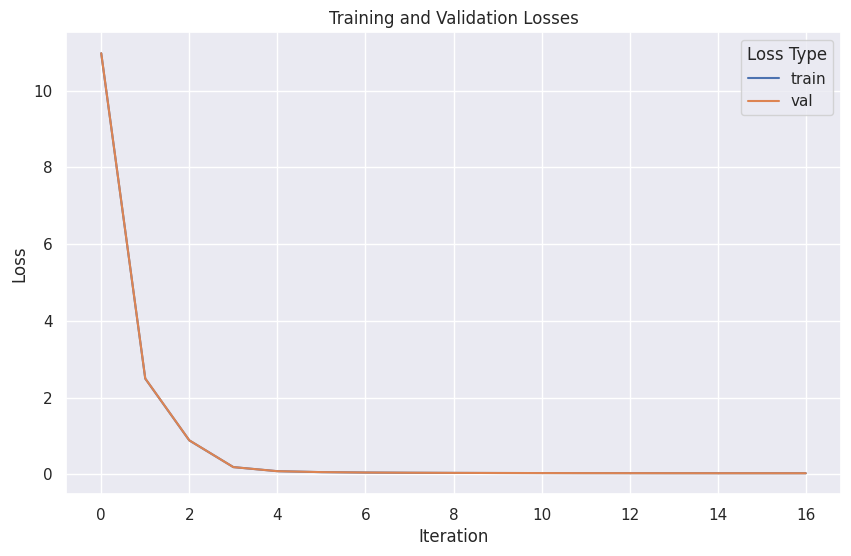

In [34]:
df = pd.DataFrame({
    'iter': range(len(all_losses[DataSplit.TRAIN.name])),
    'train': all_losses[DataSplit.TRAIN.name],
    'val': all_losses[DataSplit.VALIDATION.name]
})

# Melt the DataFrame to create a "long-form" DataFrame
df_melted = pd.melt(df, id_vars=['iter'], value_vars=['train', 'val'],
                    var_name='loss_type', value_name='loss')

# Create the plot
sns.set_theme()
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_melted, x='iter', y='loss', hue='loss_type')

plt.title('Training and Validation Losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(title='Loss Type')

plt.show()

In [35]:
!mkdir -p weights

In [36]:
torch.save(model, 'weights/tinyGPT.pb')

In [37]:
upload_file('weights/tinyGPT.pb')

Uploading file with, filepath: weights/tinyGPT.pb


RedirectMissingLocation: Redirected but the response is missing a Location: header.

In [38]:
!zip -r weights/train_result.zip weights checkpoints

  adding: weights/ (stored 0%)
  adding: weights/tinyGPT.pb (deflated 12%)
  adding: checkpoints/ (stored 0%)
  adding: checkpoints/checkpoint_3499.pt (deflated 31%)
  adding: checkpoints/logs.zip (stored 0%)
  adding: checkpoints/checkpoint_499.pt (deflated 31%)
  adding: checkpoints/checkpoint_1999.pt (deflated 31%)
  adding: checkpoints/checkpoint_2499.pt (deflated 31%)
  adding: checkpoints/checkpoint_2999.pt (deflated 31%)
  adding: checkpoints/checkpoint_1499.pt (deflated 31%)
  adding: checkpoints/checkpoint_3999.pt (deflated 31%)
  adding: checkpoints/checkpoint_4499.pt (deflated 31%)
  adding: checkpoints/checkpoint_4999.pt (deflated 31%)
  adding: checkpoints/checkpoint_999.pt (deflated 31%)
  adding: checkpoints/logs/ (stored 0%)
  adding: checkpoints/logs/run_1736270290.log (stored 0%)
  adding: checkpoints/latest.txt (deflated 20%)


In [39]:
upload_file('weights/train_result.zip')

Uploading file with, filepath: weights/train_result.zip


RedirectMissingLocation: Redirected but the response is missing a Location: header.

In [40]:
files.download('weights/train_result.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>